# Projeto 10 - Regressão com multiplas saídas - venda de video games

## 1. Importando as bibliotecas

In [1]:
import pandas as pd
import torch
import seaborn as sns
from torch import nn, optim
import torch.nn.functional as F
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

In [2]:
torch.set_default_device("mps")
device = torch.device("mps")

# torch.set_default_device("cpu")
# device = torch.device("cpu")

In [3]:
print(torch.backends.mps.is_available())  # Deve retornar True
print(torch.backends.mps.is_built())  # Deve retornar True

True
True


## 2. Importando base de dados

In [4]:
torch.manual_seed(123)

In [5]:
base = pd.read_csv("data/games.csv")

In [6]:
base.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
base.shape

(16719, 16)

In [8]:
base.drop(columns=["Other_Sales", "Global_Sales", "Developer"], inplace=True)

In [9]:
base.shape

(16719, 13)

<Axes: >

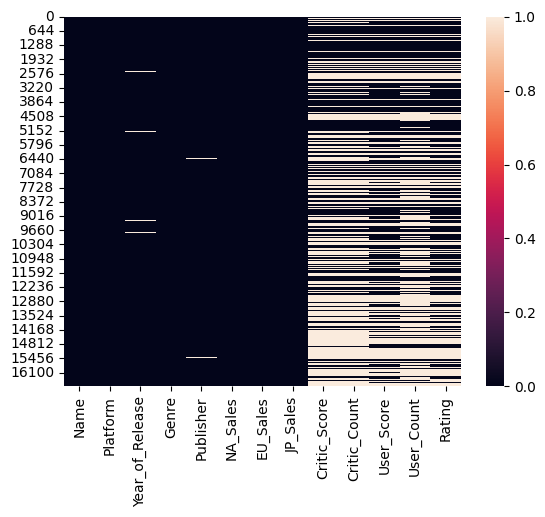

In [10]:
sns.heatmap(base.isnull())

In [11]:
base.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Rating             6769
dtype: int64

In [12]:
base.dropna(axis=0, inplace=True)

<Axes: >

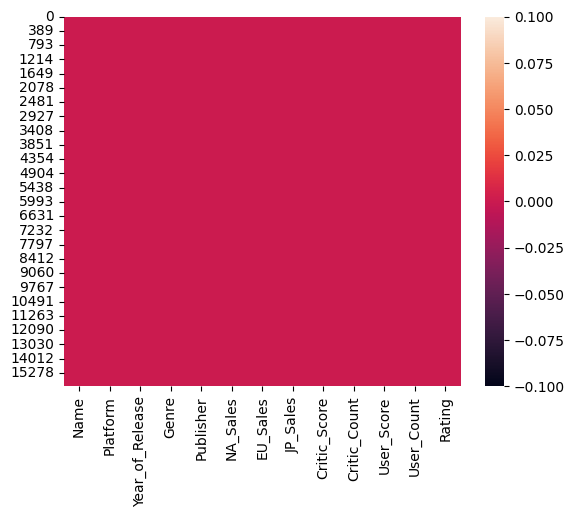

In [13]:
sns.heatmap(base.isnull())

In [14]:
base.shape

(6825, 13)

In [15]:
base[base["NA_Sales"] > 1]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,NCAA Football 14,X360,2013.0,Sports,Electronic Arts,1.01,0.00,0.00,77.0,18.0,5.8,74.0,E
1877,NFL 2K1,DC,2000.0,Sports,Sega,1.02,0.05,0.00,97.0,22.0,6,47.0,E
1881,Madden NFL 2004,XB,2003.0,Sports,Electronic Arts,1.02,0.02,0.00,92.0,27.0,8.3,48.0,E
1889,NCAA Football 13,X360,2012.0,Action,Electronic Arts,1.02,0.00,0.00,76.0,20.0,5.5,65.0,E


In [16]:
base = base[base["NA_Sales"] > 1]

In [17]:
base.shape

(584, 13)

In [18]:
base[base["EU_Sales"] > 1]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,Medal of Honor,PS,1998.0,Shooter,Electronic Arts,1.44,1.09,0.00,92.0,17.0,8.6,80.0,T
573,Tom Clancy's Splinter Cell,PS2,2003.0,Action,Ubisoft,1.15,1.11,0.00,89.0,24.0,7.7,102.0,T
591,Mario Strikers Charged,Wii,2007.0,Sports,Nintendo,1.05,1.05,0.24,79.0,47.0,8,124.0,E10+
610,Crazy Taxi,PS2,2001.0,Racing,Acclaim Entertainment,1.13,1.12,0.06,80.0,15.0,7.9,46.0,T


In [19]:
base = base[base["EU_Sales"] > 1]

In [20]:
base.shape

(258, 13)

In [21]:
base["Name"].value_counts()

Name
Grand Theft Auto V                 4
Assassin's Creed IV: Black Flag    3
Call of Duty: Ghosts               3
Battlefield 4                      3
The Elder Scrolls V: Skyrim        3
                                  ..
Tekken 2                           1
Destiny                            1
Cooking Mama                       1
Forza Motorsport 3                 1
The Sims: Bustin' Out              1
Name: count, Length: 223, dtype: int64

In [22]:
base = base.drop('Name', axis=1)

In [23]:
base.shape

(258, 12)

In [24]:
previsores = base.drop(columns=["NA_Sales", "EU_Sales", "JP_Sales"])
vendas = base[["NA_Sales", "EU_Sales", "JP_Sales"]]

In [25]:
previsores

,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii,2006.0,Sports,Nintendo,76.0,51.0,8,322.0,E
2,Wii,2008.0,Racing,Nintendo,82.0,73.0,8.3,709.0,E
3,Wii,2009.0,Sports,Nintendo,80.0,73.0,8,192.0,E
6,DS,2006.0,Platform,Nintendo,89.0,65.0,8.5,431.0,E
7,Wii,2006.0,Misc,Nintendo,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...
568,PS,1998.0,Shooter,Electronic Arts,92.0,17.0,8.6,80.0,T
573,PS2,2003.0,Action,Ubisoft,89.0,24.0,7.7,102.0,T
591,Wii,2007.0,Sports,Nintendo,79.0,47.0,8,124.0,E10+
610,PS2,2001.0,Racing,Acclaim Entertainment,80.0,15.0,7.9,46.0,T


In [26]:
vendas

,NA_Sales,EU_Sales,JP_Sales
0,41.36,28.96,3.77
2,15.68,12.76,3.79
3,15.61,10.93,3.28
6,11.28,9.14,6.50
7,13.96,9.18,2.93
...,...,...,...
568,1.44,1.09,0.00
573,1.15,1.11,0.00
591,1.05,1.05,0.24
610,1.13,1.12,0.06


In [27]:
onehotencoder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [0, 2, 3, 8])], 
                                  remainder='passthrough')
previsores = onehotencoder.fit_transform(previsores).toarray()

In [28]:
previsores.shape

(258, 61)

## 3. Construção dos modelos

In [29]:
class regressor_torch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dense0 = nn.Linear(61, 32)

        self.dense1 = nn.Linear(32, 32)

        self.activation = nn.Sigmoid()
        self.output = nn.Linear(32, 3)

    def forward(self, X):
        X = self.dense0(X)
        X = self.activation(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.output(X)
        return X

In [30]:
regressor = regressor_torch()

In [31]:
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

In [32]:
type(previsores)

numpy.ndarray

In [33]:
previsores = torch.tensor(previsores, dtype=torch.float)
vendas = torch.tensor(np.array(vendas), dtype=torch.float)

In [34]:
dataset = torch.utils.data.TensorDataset(previsores, vendas)
train_loader = torch.utils.data.DataLoader(dataset, 
                                           batch_size=10,
                                           shuffle=True,
                                           pin_memory=False,  # MPS não suporta pin_memory=True
                                           generator=torch.Generator(device=device))

In [35]:
regressor.to(device)

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

## 4. Treinamento

In [36]:
for epoch in range(2000):
    
    running_loss = 0.
    running_mse_0 = 0.
    running_mse_1 = 0.
    running_mse_2 = 0.
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()

        outputs = regressor(inputs)

        mse_0 = F.mse_loss(outputs[:,0], labels[:,0]).item()
        mse_1 = F.mse_loss(outputs[:,1], labels[:,1]).item()
        mse_2 = F.mse_loss(outputs[:,2], labels[:,2]).item()
        
        running_mse_0 += mse_0 * len(inputs)
        running_mse_1 += mse_1 * len(inputs)
        running_mse_2 += mse_2 * len(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        loss = loss.item()
        running_loss += loss * len(inputs)

        print('\rEpoch {:4d} - Loop {:3d} of {:3d}: erro_0 {:6.4f} | erro_1 {:6.4f} | erro_2 {:6.4f} - cost {:6.4f}'.format(epoch + 1,
                      i + 1,
                      len(train_loader),
                      mse_0,
                      mse_1,
                      mse_2,
                      loss), end = '\r')
        
    print('Final Epoch {:4d}: erro_0 {:6.4f} | erro_1 {:6.4f} | erro_2 {:6.4f} - cost {:6.4f}         '.format(epoch + 1, 
         running_mse_0/len(dataset), 
         running_mse_1/len(dataset), 
         running_mse_2/len(dataset), 
         running_loss/len(dataset)))
        

Final Epoch    1: erro_0 20.9353 | erro_1 10.6215 | erro_2 1.8944 - cost 11.1504         3297
Final Epoch    2: erro_0 17.6073 | erro_1 8.6926 | erro_2 1.4168 - cost 9.2389         559122
Final Epoch    3: erro_0 15.0722 | erro_1 7.2929 | erro_2 1.2293 - cost 7.8648         411663
Final Epoch    4: erro_0 13.4454 | erro_1 6.4313 | erro_2 1.1760 - cost 7.0176         184155
Final Epoch    5: erro_0 12.5658 | erro_1 6.0420 | erro_2 1.1729 - cost 6.5936         356005
Final Epoch    6: erro_0 12.1957 | erro_1 5.9149 | erro_2 1.1701 - cost 6.4269         420212
Final Epoch    7: erro_0 12.0498 | erro_1 5.8735 | erro_2 1.1695 - cost 6.3643         889864
Final Epoch    8: erro_0 12.0159 | erro_1 5.8672 | erro_2 1.1682 - cost 6.3504         434721
Final Epoch    9: erro_0 11.9683 | erro_1 5.8610 | erro_2 1.1694 - cost 6.3329         405169
Final Epoch   10: erro_0 11.9740 | erro_1 5.8639 | erro_2 1.1696 - cost 6.3359         815931
Final Epoch   11: erro_0 11.9693 | erro_1 5.8641 | erro_2 1.

## 5. Avaliação

In [38]:
regressor.eval()

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [39]:
previsores = previsores.to(device)

In [40]:
previsoes = regressor.forward(previsores)
previsoes

tensor([[3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.1443, 2.6608, 0.1285],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2615, 2.7203, 0.2492],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.2839, 2.3539, 0.5842],
        [3.283

In [41]:
previsoes = previsoes.detach().cpu().numpy()

In [42]:
previsoes

array([[3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.1443453 , 2.6608431 , 0.12847343],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.283905  , 2.3539102 , 0.58423114],
       [3.2614603 , 2.7203434 , 0.24920502],
       [3.

In [45]:
previsoes.mean(axis=0)

array([3.2803226, 2.3667264, 0.5684367], dtype=float32)

In [46]:
vendas.mean(axis=0)

tensor([3.2838, 2.3505, 0.5862], device='mps:0')

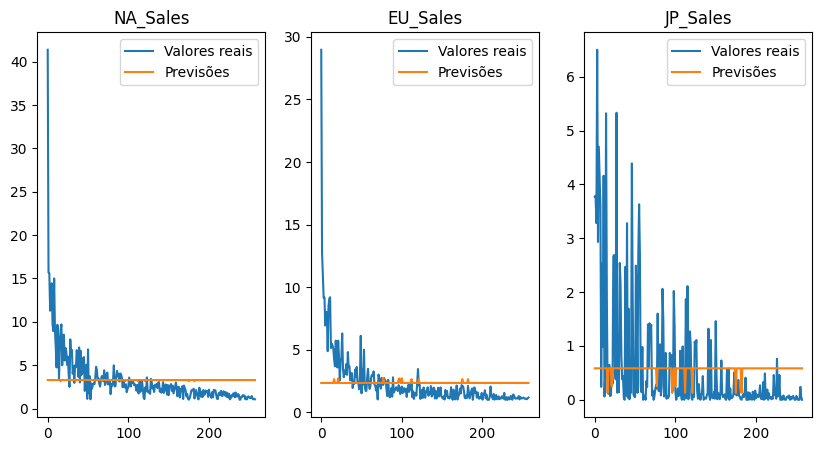

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax[i].plot(vendas[:, i].cpu())
    ax[i].plot(previsoes[:, i])
    ax[i].legend(['Valores reais', 'Previsões'])
    ax[i].set_title(base.columns[4 + i])